# ORIE 4580/5580/5581 Assignment 3

#### Students: Kanishk Agarwal (ka556) and Pratvi Shah (ps2279)


#### Github Link: https://github.com/Pratvi27/ORIE5581/blob/main/ORIE5581-SimulationHW3.ipynb

### Instructions


* Due Thursday September 25, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [31]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
%matplotlib inline
import math
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'
# Choosing a colormap for the plot colors
cmap=plt.get_cmap('Set3')

<hr><hr>

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats\ldots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) \mbox{ mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) \mbox{ mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) \mbox{ mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


<hr>

**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).

<hr>

In [32]:
# Functions to visualize LCG sequence on clock (code from demo notebook)
def plot_clock_face(m, fig, annotate=False):
    """
    Plot points on a unit circle representing the LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    annotate (bool): Whether to annotate points with their index.

    Returns:
    None
    """
    # Plot m points on the unit circle
    for i in range(m):
        theta = 2.0 * np.pi * i / m
        plt.plot(np.sin(theta), np.cos(theta), 'rs', markersize = 10)
        if annotate:
            plt.annotate(str(i), (np.pi/2 - theta, 1.05), xycoords='polar')

def plot_clock_path(m, x, fig, color='y'):
    """
    Plot the path of an LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    x (numpy.ndarray): The LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    color (str): The color for the path.

    Returns:
    None
    """
    # Plot the seed node
    theta_0 = 2.0 * np.pi * (x[0] * (m + 1) - 1) / m
    plt.plot(np.sin(theta_0), np.cos(theta_0), 'gs', markersize = 10)

    # Plot the path of the LCG sequence
    for i in range(len(x) - 1):
        theta_start = 2.0 * np.pi * (x[i] * (m + 1) - 1) / m
        theta_end = 2.0 * np.pi * (x[i + 1] * (m + 1) - 1) / m
        x_start = np.sin(theta_start)
        y_start = np.cos(theta_start)
        del_x = np.sin(theta_end) - np.sin(theta_start)
        del_y = np.cos(theta_end) - np.cos(theta_start)
        if abs(del_x) > 0 or abs(del_y) > 0:
            plt.arrow(x_start, y_start, del_x, del_y,
                      length_includes_head=True, head_width=0.05, head_length=0.1, fc=color, ec=color)

def plot_clock_figure(ym, y):
  fig = plt.figure(figsize=(5,5))
  plot_clock_face(ym,fig,annotate = True)
  plot_clock_path(ym,y,fig)
  plt.axis('off')
  plt.show()


In [33]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (code from demo notebook)
def LCG(n, m=2**31-1, a=1103515245, c=12345, seed=1):
    """
    Generate a pseudorandom sequence using a Linear Congruential Generator (LCG).

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    m (int): The modulus value (default is 2^31-1, following glibc specifications).
    a (int): The multiplier value (default is 1103515245, following glibc specifications).
    c (int): The increment value (default is 12345, following glibc specifications).
    seed (int): The initial seed value (default is 1).

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    x = seed
    for i in range(n):
        # Calculate the pseudorandom number and normalize it to [0, 1)
        output[i] = (x + 1.0) / (m + 1.0)

        # Update the LCG state using the specified parameters
        x = (a * x + c) % m

    return output

In [34]:
# Ans
xm = 16
xa = 5

ym = 7
ya = 2

c = 0
seed = 1

x = LCG(n=xm+1,m=xm,a=xa,c=c,seed = seed)
y = LCG(n=ym+1,m=ym,a=ya,c=c,seed = seed)

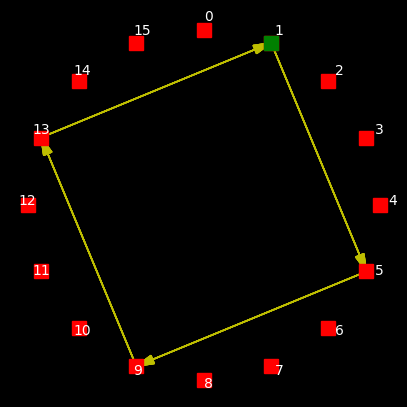

In [35]:
plot_clock_figure(xm, x)

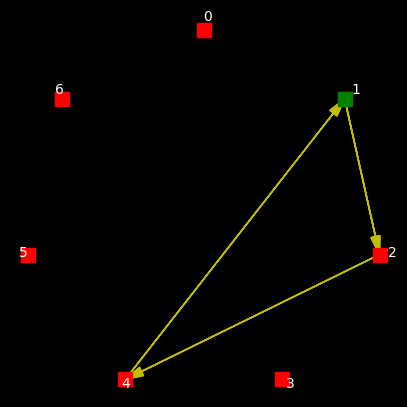

In [36]:
plot_clock_figure(ym, y)

<hr>

**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.

<hr>

In [37]:
y_new = np.concatenate((y, y, y[:2]))
y_new.shape

(18,)

In [38]:
z = []
for i in range(len(x)):
    z.append((x[i]+y_new[i])%16)


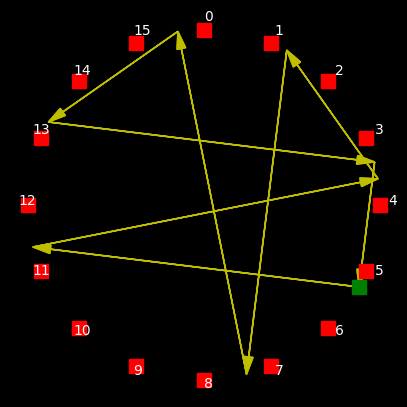

In [39]:
plot_clock_figure(xm, z)

___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.

Period will be the number of points after which the pattern repeats. So,

Period of $x_n$ = 4

Period of $y_n$ = 3

Period of $z_n$ = 7


___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___

### Ans.

Given the mixed CDF:
$$F(x) = \begin{cases}
0 & \text{for } x < 0 \\
x & \text{for } 0 \leq x < \frac{1}{2} \\
\frac{1}{2} & \text{for } \frac{1}{2} \leq x < 1 \\
1 & \text{for } x \geq 1
\end{cases}$$

To find the pseudoinverse $F^{-1}(y)$, we need to find $\inf\{x | F(x) \geq y\}$ for each $y \in [0,1]$.

Breaking it down into intervals:
- For $y = 0$:
$$F^{-1}(0) = 0 \quad (\because F(0) = 0)$$

- For $0 < y < \frac{1}{2}$:
$$F(x) = x \text{ for }x \in [0, \frac{1}{2})$$
$$x = F^{-1}(x) \implies y = F^{-1}(y)$$
$$\therefore F^{-1}(y) = y $$

- For $y = \frac{1}{2}$:
$$F^{-1}(\frac{1}{2}) = \frac{1}{2} \quad (\because F(\frac{1}{2}) = \frac{1}{2})$$

- For $\frac{1}{2} < y < 1$: Find min $x$ such that $F(x) \ge y$
$$F(x) = \frac{1}{2} < y \quad \forall x < 1, \text{ but } F(1) = 1 \geq y)$$
$$\therefore F^{-1}(y) = 1$$
- For $y = 1$: $F^{-1}(1) = 1$

Therefore, the pseudoinverse is:
$$F^{-1}(y) = \begin{cases}
y & \text{for } 0 \leq y \leq \frac{1}{2} \\
1 & \text{for } \frac{1}{2} < y \leq 1
\end{cases}$$

___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

### Ans.

To find pseudo inverse we first need the cmf:
\begin{align*}
p(k) & = p(1-p)^{k-1}\\
P(k) & = P(x\le k)\\
& = 1 - P(x > k)\\
& = 1 - ∑_{i=k+1}^{∞} p(i)\\
& = 1 - ∑_{i=k}^{∞}p(1-p)^{(i)}\\
& = 1 - p(1-p)^k(1 + (1-p) + (1-p)^2 ...)\\
& = 1 - \frac{p(1-p)^k}{1 - (1-p)}\\
& = 1 - (1 -p)^k
\end{align*}


Now lets find psuedoinverse, $P^{−1}(u)=inf\{k|P(k)≥u\} \quad u \in [0, 1]$:
\begin{align*}
P(k) &= 1 - (1-p)^k \ge u\\
1 - u & \ge (1-p)^k\\
log(1-u) & \le klog(1-p)\\
\frac{log(1-u)}{log(1-p)} &\le k
\end{align*}

We need to find min $k$ which satisfies the above condition and it should be an integer

$$\therefore k = P^{-1}(u) = ⌈\frac{log(1-u)}{log(1-p)}⌉$$



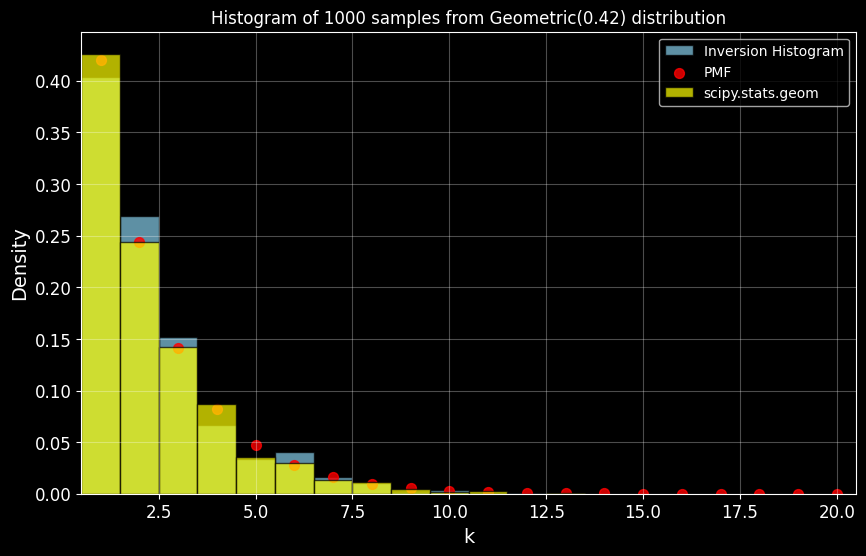

In [40]:
def geometric_inversion(p, n):
    u = np.random.uniform(0, 1, n)
    k = np.ceil(np.log(1 - u) / np.log(1 - p))
    return k.astype(int)

p = 0.42
n = 1000
geometric_samples = geometric_inversion(p, n)
plt.figure(figsize=(10, 6))
bins = np.arange(1, max(geometric_samples)) - 0.5
plt.hist(geometric_samples, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Inversion Histogram')

# Plot pmf for comparison
k = np.arange(1, 21)
pmf = p * (1 - p)**(k - 1)
plt.scatter(k, pmf, color='red', s=50, alpha=0.8, label='PMF')


# Plot histogram using scipy.stat
scipy_samples = sc.geom.rvs(p, size=1000)
plt.hist(scipy_samples, bins=bins, density=True, alpha=0.7, color='yellow', edgecolor='black', label='scipy.stats.geom')

plt.xlabel('k')
plt.ylabel('Density')
plt.title('Histogram of 1000 samples from Geometric(0.42) distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.5, 20.5)
plt.show()

___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.

Lets start by finding the CDF:

\begin{align*}
F(x) & = ∫f(x)dx\\
& =
	\begin{cases}
		∫_0^xe^{t-2}dt & \text{for }0 \leq x \leq 2, \\\\
		F(2) + ∫_2^xe^{-t}dt & \text{for }x > 2
	\end{cases}\\\\
& =
	\begin{cases}
		e^{x-2} - e^{-2} & \text{for }0 \leq x \leq 2, \\\\
		1 - e^{-2} + e^{-2} - e^{-x} & \text{for }x > 2
	\end{cases}\\\\
& =
	\begin{cases}
		e^{x-2} - e^{-2} & \text{for }0 \leq x \leq 2, \\\\
		1 - e^{-x} & \text{for }x > 2
	\end{cases}\\\\
\end{align*}


Now lets find the pseudoinverse:

For $0 \leq x \leq 2:$
\begin{align*}
F(x) & = u\\
u & =
		e^{x-2} - e^{-2} \\
    u e^{2} & = e^x - 1\\
    x & = log (ue^2 + 1)\\
    F^{-1}(u) & = log (ue^2 + 1)
\end{align*}

For $x > 2:$
\begin{align*}
F(x) & = u\\
u & = 1 - e^{-x} \\
    e^{-x} & = 1 - u\\
    x & = -log (1 - u)\\
    F^{-1}(u) & = -log (1 - u)\\\
\end{align*}

Therefore, pseudoinverse can be given as:
\begin{align*}
F^{-1}(u)& =
	\begin{cases}
		log (ue^2 + 1) & \text{for }0 \leq x \leq 2,≡ F^{-1}(u) \leq 2 \equiv u\le F(2) \equiv u\le 1-e^{-2} \\\\
		-log (1 - u) & \text{for }x > 2 ≡ F^{-1}(u) > 2 \equiv u > F(2) \equiv u > 1-e^{-2}
	\end{cases}\\\\
  & =
	\begin{cases}
		log (ue^2 + 1) & \text{for }u\le1-e^{-2} \\\\
		-log (1 - u) & \text{for } u > 1-e^{-2}
	\end{cases}
  \end{align*}


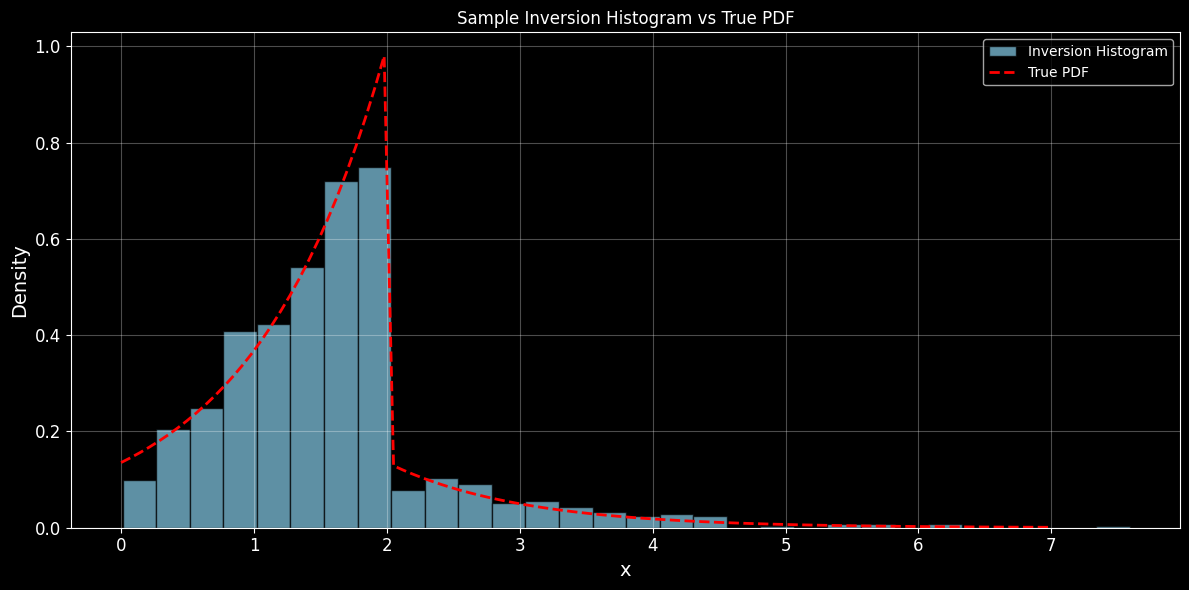

In [41]:
def pdf_custom(x_sample):
  ans = [np.exp(x - 2) if (x >= 0 and x <= 2) else np.exp(-x) for x in x_sample]
  return ans

def inversion_custom(u_sample):
  ans = [np.log(u * np.exp(2) + 1) if u <= 1 - np.exp(-2) else -np.log(1 - u) for u in u_sample]
  return ans

def generate_inversion_sample(n):
  u = np.random.uniform(0, 1, n)
  return inversion_custom(u)


n = 1000
samples = generate_inversion_sample(n)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Inversion Histogram')

x_range = np.linspace(0, 7, 100)
true_pdf = pdf_custom(x_range)
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sample Inversion Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<hr><hr>

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

<hr>

**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

<hr>

### Ans.

Lets find M such that $ \quad M \ge f(x) \quad \forall x \in [0, 1]$:

\begin{align*}
f'(x) & = \frac{20x^3 + 12x^2 + 6x}{4} = 0\\
& = \frac{x(10x^2 + 6x + 3)}{2}\\\\\\
f''(x) & = \frac{60x^2 + 24x + 6}{4}
\end{align*}

We see that $f'(x)=0$ for only $x=0$, other roots are imaginary. And $f''(0) > 0$, hence $x=0$ forms the minimum and $f(x)$ is increasing otherwise in the interval.

Therefore, $M = max(f(x)) = f(1) = 3.25$

Lets generate the acceptance-rejection algorithm:
1.  Taking two uniformly distributed random variables $U_1$ and $U_2$ st $U_1, U_2 = U[0, 1]$
2.  Let $Z_1 = 0 + (1-0)U_1 = U_1$ and $Z_2 = MU_2 = 3.25U_2$
3. If $Z_2 \le f(Z_1)$ $\quad \equiv U_2 \le f(U_1)/3.25$ , then accept it and return $X = Z_1$, otherwise reject it and move to next sample.









<hr>

**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?

<hr>

### Ans.

\begin{align*}
P(\text{accepting X}) = P(Z_2\le f(Z_1))
& = ∫_{U_1}\frac{ f(U_1) }{ M} \\
& = \frac{1}{M}
\end{align*}

Number of Trials to get one sample of X = $\frac{1}{P(\text{accepting X})} = M$

Each trial needs two uniform variables $U_1, U_2$

 $\therefore N = 2M = 6.5$


<hr>

**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.

<hr>

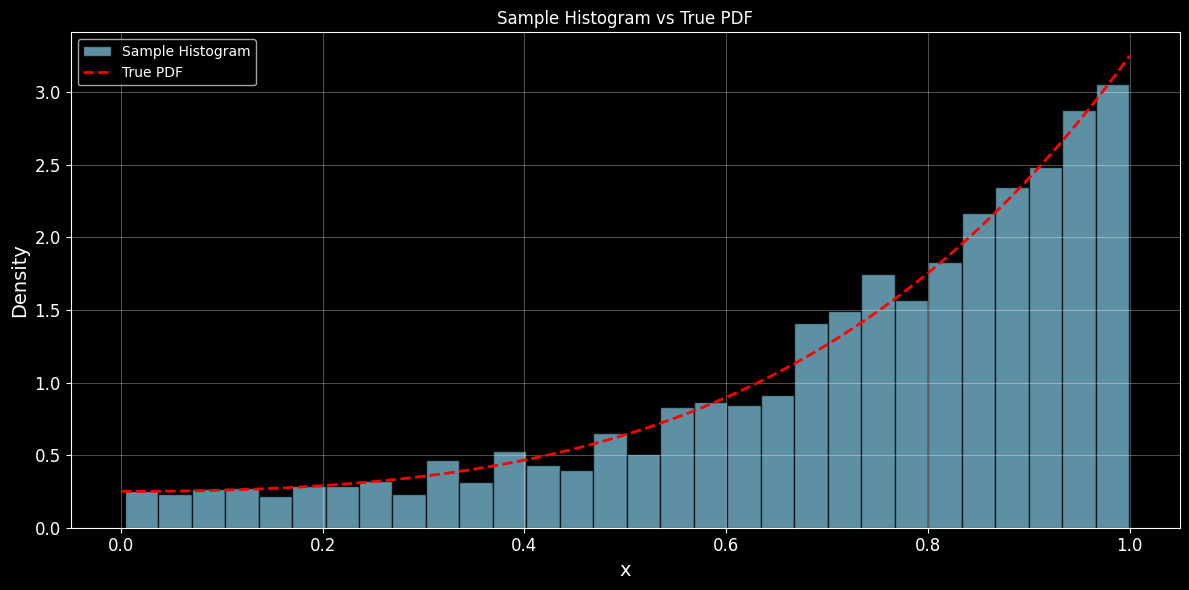

In [42]:
def q3cf(x):
  return (5*x**4 + 4*x**3 + 3*x**2 + 1)/4

def given_pdf(x_sample):
  ans = [ q3cf(x) for x in x_sample]
  return ans

def acceptance_rejection_criteria(n):
  u1 = np.random.uniform(0, 1)
  u2 = np.random.uniform(0, 1)
  if u2 <= q3cf(u1)/3.25:
    return u1
  else:
    return -1

def acceptance_rejection_sample(n):
  samples = []
  while len(samples) < n:
    sample = acceptance_rejection_criteria(n)
    if sample != -1:
      samples.append(sample)
  return samples


n = 2500
samples = acceptance_rejection_sample(n)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Sample Histogram')

x_range = np.linspace(0, 1, 100)
true_pdf = given_pdf(x_range)
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sample Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<hr><hr>

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a ${N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

<hr>

**(a)** First, suppose we choose the proposal distribution to be a \emph{Laplace} (i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.

<hr>

### Ans.


LEts start by finding the CDF:

\begin{align*}
G(x) &= \int_{- ∞}^x g(t) dt\\
& =
	\begin{cases}
		∫_{-∞}^x\frac{e^{t}}{2}dt & \text{for }t \le 0, \\\\
		G(0) + ∫_0^x\frac{e^{-t}}{2}dt & \text{for }t > 0
	\end{cases}\\\\
& =
	\begin{cases}
		\frac{e^{x}}{2} & \text{for }x \le 0, \\\\
		G(0) + \frac{1 - e^{-x}}{2} & \text{for }x > 0
	\end{cases}\\\\
& =
	\begin{cases}
		\frac{e^{x}}{2} & \text{for }x \le 0, \\\\
		1 - \frac{e^{-x}}{2} & \text{for }x > 0
	\end{cases}\\\\
\end{align*}

Now, lets invert this for $u\in[0,1]$ and $G(x) = u$:

For $x \le 0 \equiv u \le \frac{1}{2}$
\begin{align*}
G(x) &=
		\frac{e^{x}}{2} = u\\
    x & = ln(2u)
\end{align*}

For $x > 0 \equiv u > \frac{1}{2}$
\begin{align*}
G(x) &=
		1 - \frac{e^{-x}}{2} = u\\
    1 - u & = \frac{e^{-x}}{2}\\
    x & = -ln(2(1-u))
\end{align*}

Therefore,

\begin{align*}
G^{-1}(u)
& =
	\begin{cases}
		ln(2u)& \text{for }u \le \frac{1}{2}, \\\\
		-ln(2(1-u)) &\text{for } u > \frac{1}{2}
	\end{cases}
  \end{align*}



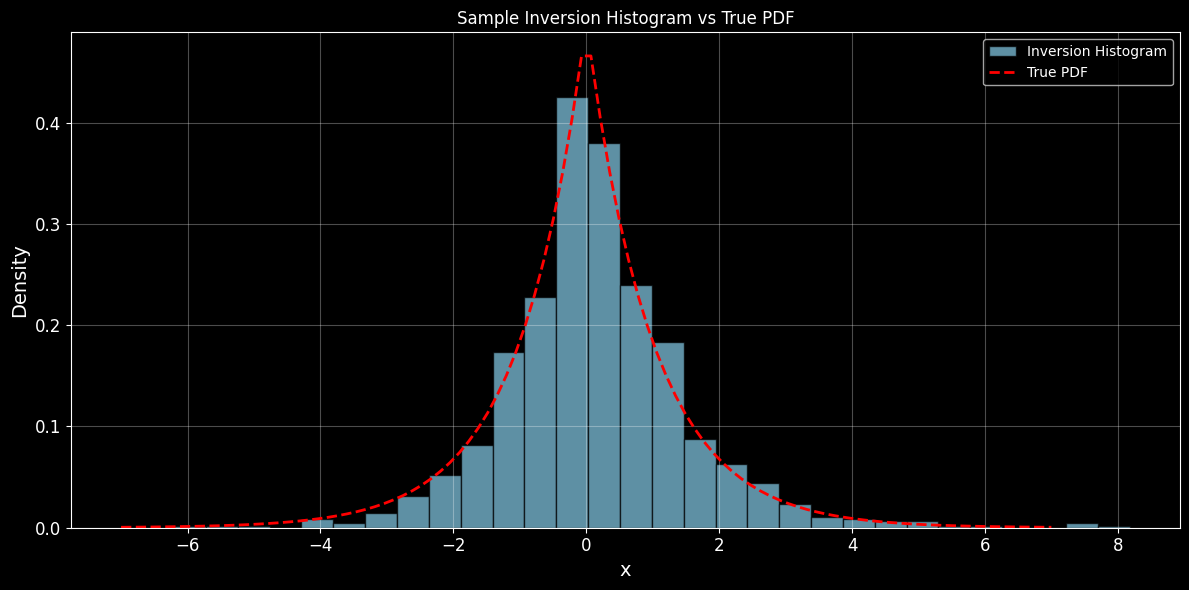

In [43]:
def pdf_custom(x_sample):
  ans = [np.exp(-np.abs(x))/2 for x in x_sample]
  return ans

def inversion_custom(u_sample):
  ans = [np.log(2*u) if u <= 1/2 else -np.log(2 - 2*u) for u in u_sample]
  return ans

def generate_inversion_sample(n):
  u = np.random.uniform(0, 1, n)
  return inversion_custom(u)


n = 1000
samples = generate_inversion_sample(n)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Inversion Histogram')

x_range = np.linspace(-7, 7, 100)
true_pdf = pdf_custom(x_range)
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sample Inversion Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<hr>

**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim{N}(0,1)$, and compute the expected number of samples needed for generating each sample.

<hr>

### Ans.

\begin{align*}
k &\ge \frac{f(x)}{g(x)}\\\\
 & \ge
 \frac{\frac{e^{-x^2/2}}{\sqrt{2\pi}}}{\frac{e^{-|x|}}{2}}\\\\
 & \ge
 \sqrt{\frac{2}{\pi}}e^{|x|-x^2/2}\\\\
\end{align*}


\begin{align*}
h(x) & = |x|-x^2/2\\
\end{align*}

Finding max(h(x)) for $x\ge 0$

\begin{align*}
h'(x) & = 1-x = 0\\
x & = 1\\
h(1) &= 1/2\\
k & \ge
 \sqrt{\frac{2e}{\pi}} = 1.315489
\end{align*}

Finding max(h(x)) for $x< 0$

\begin{align*}
h(x) & = -x - x^2/2\\
h'(x) & = -1-x = 0\\
x & = -1\\
h(-1) &= 1/2\\
k & \ge
 \sqrt{\frac{2e}{\pi}} = 1.315489
\end{align*}

$$k = 1.3155$$

Acceptance-Rejection algorithm:
1.   Generate $U_1 \sim G^{-1}$.
2.   Generate $U_2 \sim Unif[0, k\cdot g(U_1)]$.
3.   If $U_2 \le f(U_1)$, then keep $X = U_2$. Else reject and go back to step 1.


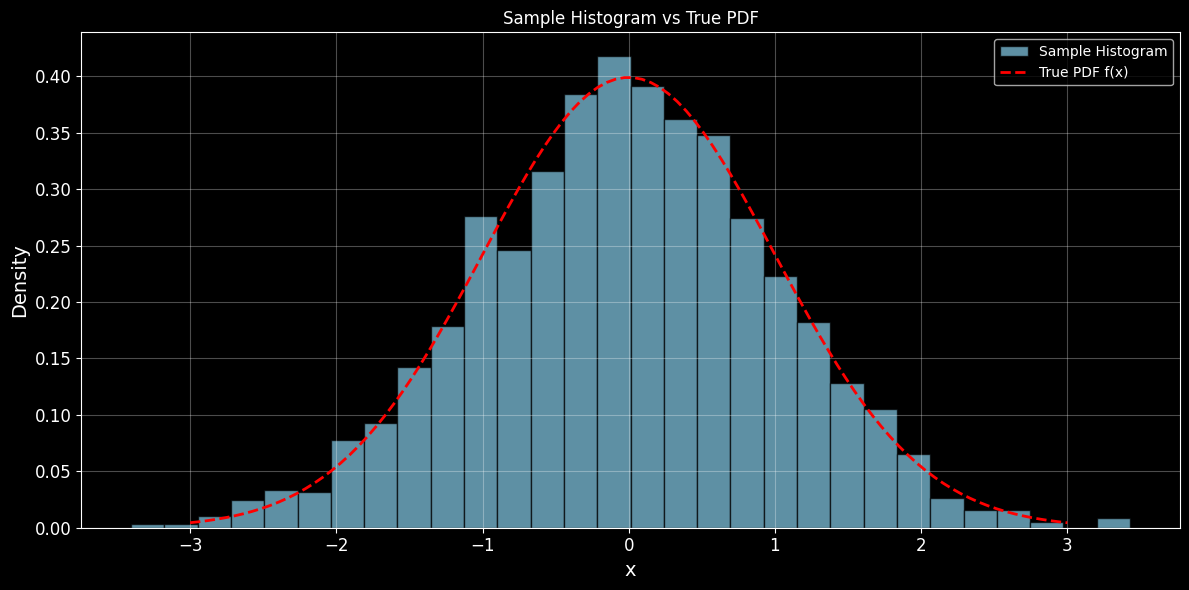

In [44]:
def q4bf(x):
  return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)

def gx(x):
  return 0.5 * np.exp(-np.abs(x))

def G_inv(x):
  if x <= 0.5:
    return np.log(2 * x)
  else:
    return -np.log(2 * (1 - x))

def acceptance_rejection_criteria(n, k):
  u = np.random.uniform(0, 1)
  u1 = G_inv(u)
  u2 = np.random.uniform(0, k*gx(u1))
  if u2 <= q4bf(u1):
    return u1
  else:
    return -1

def acceptance_rejection_sample(n, k):
  samples = []
  while len(samples) < n:
    sample = acceptance_rejection_criteria(n, k)
    if sample != -1:
      samples.append(sample)
  return samples


n = 2500
k = 1.3155
samples = acceptance_rejection_sample(n, k)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Sample Histogram')

x_range = np.linspace(-3, 3, 100)
true_pdf = [q4bf(x) for x in x_range]
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF f(x)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sample Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Just like previous question:


$$P(\text{accepting X}) = \frac{1}{k}$$

Number of trials for one acceptance: $k = 1.3155$

Two uniform random variables are needed per trial
Total variables/samples needed for one acceptance = $2k$ = 2.631

<hr>

**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.

<hr>

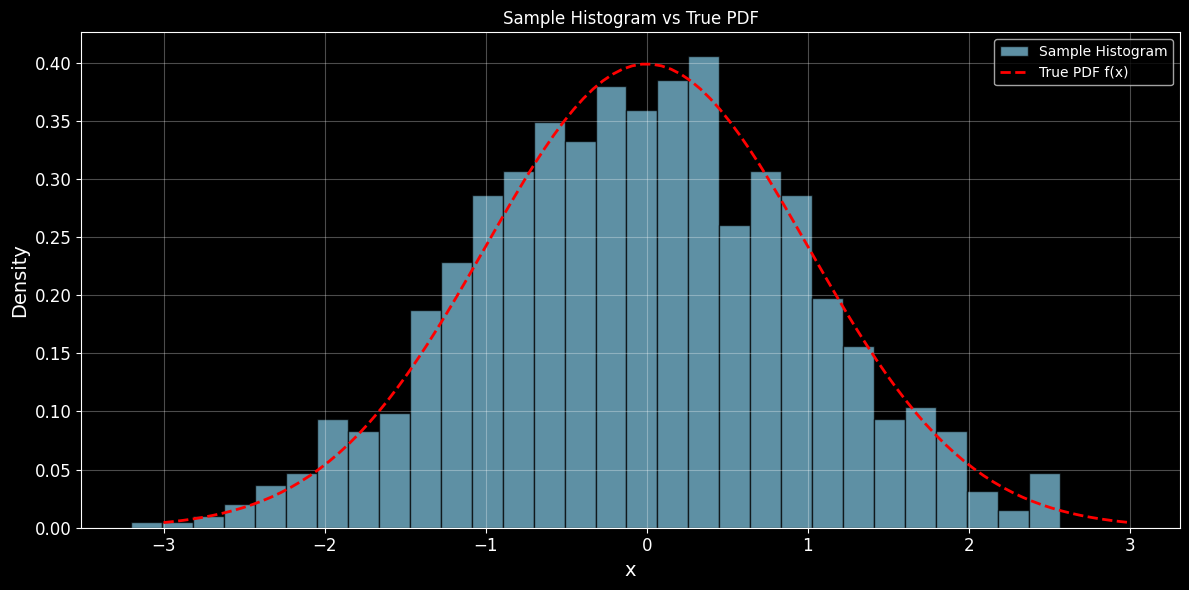

In [45]:
def q4bf(x):
  return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)

def gx(x):
  return 0.5 * np.exp(-np.abs(x))

def G_inv(x):
  if x <= 0.5:
    return np.log(2 * x)
  else:
    return -np.log(2 * (1 - x))

def acceptance_rejection_criteria(n, k):
  u = np.random.uniform(0, 1)
  u1 = G_inv(u)
  u2 = np.random.uniform(0, k*gx(u1))
  if u2 <= q4bf(u1):
    return u1
  else:
    return -1

def acceptance_rejection_sample(n, k):
  samples = []
  count=0
  while len(samples) < n:
    sample = acceptance_rejection_criteria(n, k)
    count+=2
    if sample != -1:
      samples.append(sample)
  return (samples, count)


n = 1000
k = 1.3155
samples, count = acceptance_rejection_sample(n, k)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Sample Histogram')

x_range = np.linspace(-3, 3, 100)
true_pdf = [q4bf(x) for x in x_range]
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF f(x)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sample Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
print("# of uniform random samples generated for 1000 samples of X = ", count)

# of uniform random samples generated for 1000 samples of X =  2618


On Average we saw that for 1 sample of X we need 2k = 2.631 samples.

So for 1000 samples of X we will need 2631 samples on average(=mean).

Var(# of trials for accepting X) = $\frac{1-p}{p^2} = 0.415$ where $p=(1/k)$

We need 1000 X samples, Var will be multiplies by 1000=n.

$std = \sqrt(n\frac{1-p}{p^2}) = 20.3725$

Since 2 uniform random variables are needed, std will be doubled:

CI = (mean - 1.96*2*std , mean + 1.96*2*std)

1.96*2*std = 79.86

$CI = (2551.14, 2710.86)$



<hr>

**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.

<hr>

Lets start by finding the cdf:

\begin{align*}
f(x) &= \frac{1}{\pi (1+x^2)}, \\[6pt]
F(x) &= \int_{-\infty}^x f(t)\,dt \\
&= \frac{1}{\pi}\int_{-\infty}^x \frac{1}{1+t^2}\,dt \\
F(x) &= \frac{1}{\pi}\Big[\,\arctan(t)\,\Big]_{t=-\infty}^x \\[6pt]
&= \frac{1}{\pi}\Big(\arctan(x) - \arctan(-\infty)\Big). \\[8pt]
\text{Since }\arctan(-\infty) &= -\tfrac{\pi}{2}, \\[6pt]
F(x) &= \frac{1}{\pi}\Big(\arctan(x)+\tfrac{\pi}{2}\Big). \\[8pt]
\therefore\quad
F(x) &= \frac{1}{\pi}\arctan(x) + \tfrac{1}{2}.
\end{align*}

Now lets find the pseudoinverse:


\begin{align*}
F(x) = u &= \frac{1}{\pi}\arctan(x) + \tfrac{1}{2}\\
F^{-1}(u) = x & = tan(\pi (u-0.5))
\end{align*}



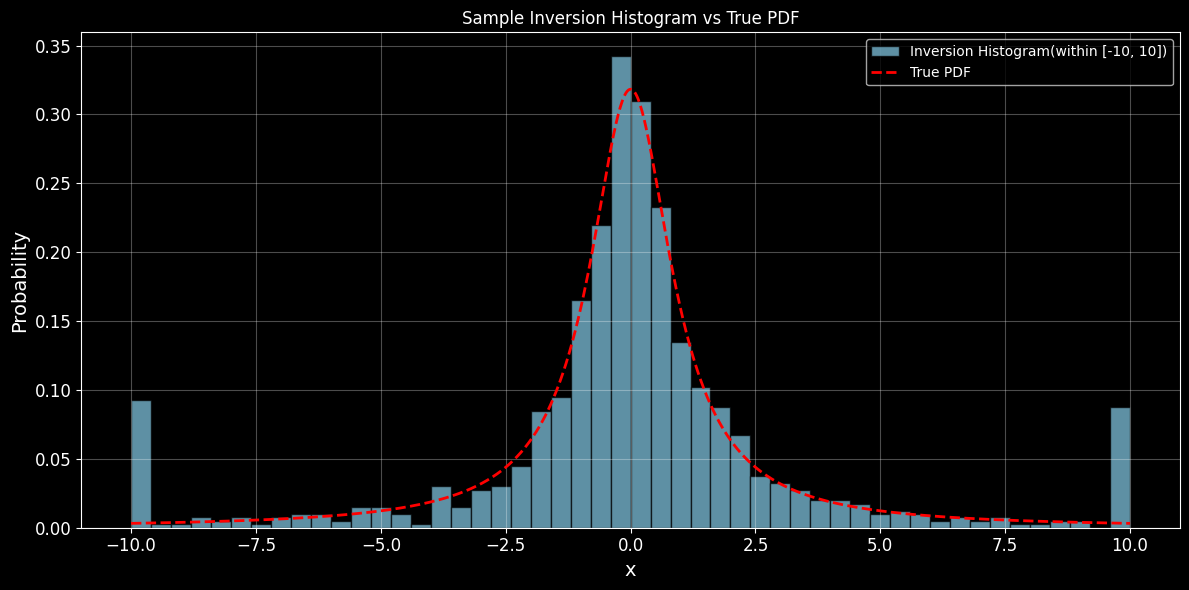

In [29]:
def pdf_custom(x_sample):
  ans = [1 / (np.pi * (1 + x**2)) for x in x_sample]
  return ans

def inversion_custom(u_sample):
  ans = [np.tan(np.pi * (u - 0.5)) for u in u_sample]
  return ans

def generate_inversion_sample(n):
  u = np.random.uniform(0, 1, n)
  return inversion_custom(u)


n = 1000
samples = generate_inversion_sample(n)
cauchy_samples= np.clip(samples, -10, 10)

plt.figure(figsize=(12, 6))
plt.hist(cauchy_samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Inversion Histogram(within [-10, 10])')

x_range = np.linspace(-10, 10, 1000)
true_pdf = pdf_custom(x_range)
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Sample Inversion Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<hr>

**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.

<hr>


We have the below functions:
$$
g(x) = \frac{1}{\pi (1 + x^2)}
$$

$$
f(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}
$$


We need to find smallest $k$ such that $$ k g(x) \geq f(x) $$

\begin{align*}
k^* &= \max\frac{f(x)}{g(x)} \\\\
& = \max \frac{\frac{1}{\sqrt{2\pi}} e^{-x^2/2}}{\frac{1}{\pi (1+x^2)}}\\\\
& = \frac{\pi}{\sqrt{2\pi}} \max \frac{e^{-x^2/2}}{1 + x^2}
\end{align*}

Maximum occurs at $x = 0$:  

$$
k^* = \frac{\pi}{\sqrt{2\pi}} \approx 1.2533
$$


Acceptance-Rejection Algorithm:

1. Generate $U_1 \sim U $, set $Y = F^{-1}(U_1) = \tan(\pi(U_1 - 0.5)) $
2. Generate $ U_2 \sim U $
3. Accept $Y $ if  $
   U_2 \leq \frac{f(Y)}{k\,g(Y)}
   $, else reject and repeat from step 1.




Expected number of uniforms samples for 1 sample of Y:  2k = 2.5066

$$ p = \frac{1}{k}$$
$$
\text{mean} = 2nk = 2506.6
$$
$$
\text{Std} = 2\sqrt{n \frac{1-p}{p^2}} = 35.635
$$

95% Confidence Interval for total uniforms:

$$
\left[
  \text{mean}
  - 1.96 \cdot \text{Std},
  \;\;
  \text{mean}
  + 1.96 \cdot \text{Std}
\right]
 \quad = \quad [2436.7554, 2576.4446]$$


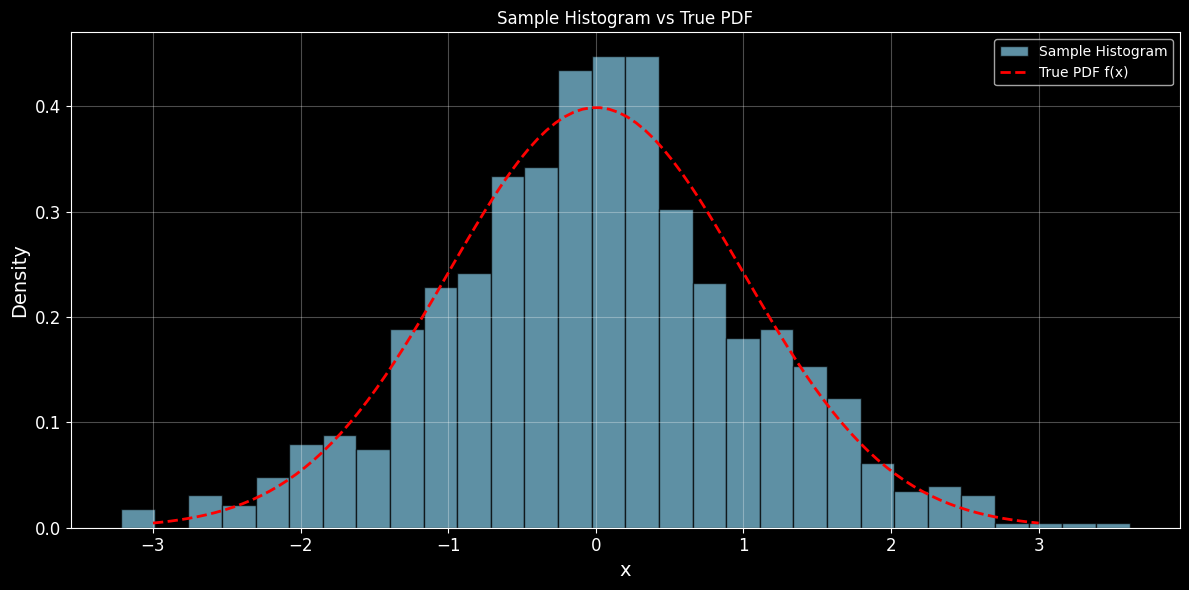

In [48]:
def q4ef(x):
  return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)

def gx(x):
  return 1/(np.pi*(1 + x**2))

def G_inv(x):
  return np.tan(np.pi*(x - 0.5))

def acceptance_rejection_criteria(n, k):
  u = np.random.uniform(0, 1)
  u1 = G_inv(u)
  u2 = np.random.uniform(0, k*gx(u1))
  if u2 <= q4bf(u1):
    return u1
  else:
    return -1

def acceptance_rejection_sample(n, k):
  samples = []
  count=0
  while len(samples) < n:
    sample = acceptance_rejection_criteria(n, k)
    count+=2
    if sample != -1:
      samples.append(sample)
  return (samples, count)


n = 1000
k = 1.2533
samples, count = acceptance_rejection_sample(n, k)

plt.figure(figsize=(12, 6))
plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Sample Histogram')

x_range = np.linspace(-3, 3, 100)
true_pdf = [q4ef(x) for x in x_range]
plt.plot(x_range, true_pdf, 'r--', linewidth=2, label='True PDF f(x)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Sample Histogram vs True PDF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()